COPY FROM t1 FOLDER: change input to have time-dependency and add LSTM model

Search for "FIXME" for tunable parameters

## Import libraries

In [1]:
print("load libraries")
import numpy as np
from sklearn.decomposition import PCA
import utils

# https://stackoverflow.com/a/34306306/4126114
np.random.seed(0)

load libraries


Using TensorFlow backend.


## Generate data

(10000, 5)
X [[ 0.62491949  0.5055217   0.88341459  0.71580412  0.21754167]
 [ 0.57287572  0.52750176  0.86901917  0.7190283   0.19393159]
 [ 0.63743994  0.74112828  0.89433874  0.88616517  0.36505651]
 [ 0.74254781  0.70066539  0.87023052  0.83520174  0.45741201]
 [ 0.74833494  0.72464035  0.74632588  0.72936087  0.48558857]
 [ 0.60420361  0.70724719  0.82916986  0.79984878  0.30990268]
 [ 0.74584635  0.85956029  0.83541036  0.90254303  0.60797459]
 [ 0.70350193  0.90362948  0.80473774  0.89552877  0.58062744]
 [ 0.72840836  0.80618286  0.72344415  0.75058165  0.53081635]
 [ 0.77918483  0.77542989  0.72196491  0.73257602  0.57682199]]


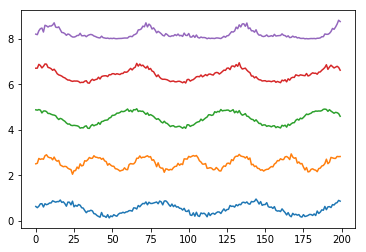

In [2]:
N=int(1e4) # FIXME 1e5

# Try dataset from https://stats.stackexchange.com/questions/190148/autoencoder-pca-tensorflow?rq=1
from sklearn.preprocessing import scale
def data1(n_samples:int=2000):
    n_features=5
    # n_samples, n_features = 2000, 5
    # X = np.random.uniform(0, 1, (n_samples, n_features))
    X = np.zeros((n_samples,n_features))
    
    sigma = 0.1
    xt=np.arange(0,n_samples/10,1/10)
    X[:,0] = .5 + .5*np.sin(1*xt) + np.random.normal(0, sigma, N) +1 # first sine wave
    X[:,1] = .5 + .5*np.sin(2*xt) + np.random.normal(0, sigma, N) +1 # second sine wave
    X[:,2] = 1*np.cos(1*xt) + np.random.normal(0, sigma, N) +1 # lagged version of first sine wave
    X[:,3] = X[:,1]*X[:, 2] # some non-linear relations between lagged and other
    X[:,4] = X[:,1]**2 * X[:, 0]**3 # some non-linear relations between 2 sines
    # auto-encoders need [0-1] range data
    # If PCA input is (mean=0,std=1) and AE is [0-1], MSE is incomparable
    # X = scale(X)
    X = utils.myNorm3(X)
    return X

X = data1(N)

print(X.shape)
print('X',X[0:10,:])

utils.myPlot(X,2)

## Try PCA

PCA
n_components =  5
err pca =  2.00756359503e-15
Explained variance ratio (cumsum) [ 0.51449386  0.7964031   0.98832351  0.99660493  1.        ]


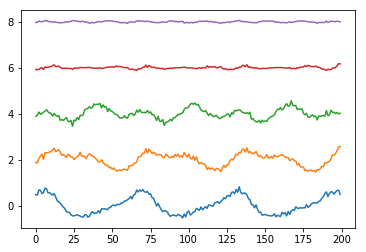

In [3]:
N_epochs = 25
n_c_i = 5
print("PCA")
pca = PCA(n_components=n_c_i, random_state=888, svd_solver = 'full')
X_pca = pca.fit_transform(X)
# print("X_pca_0",X_pca_0[0:10,:])
# print("")
# print("Explained variance ratio (cumsum)", np.cumsum(pca.explained_variance_ratio_))
# print("")
print("n_components = ",n_c_i)
utils.pca_err(X, X_pca)
print("Explained variance ratio (cumsum)", np.cumsum(pca.explained_variance_ratio_))
# plot
utils.myPlot(X_pca,2)


## Try AE7, AE10, AE15, AE20, AE25

autoencoder
n_components =  15


/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1977: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


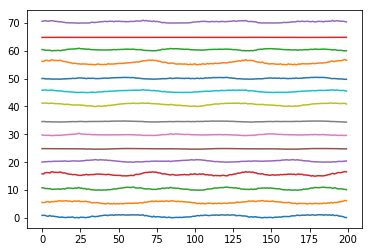

AE1 mse =  0.0392273127189


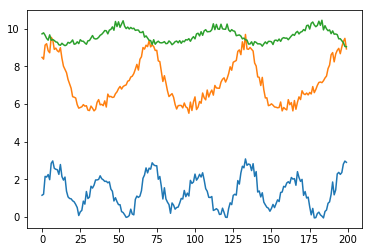

AE2 mse =  0.0661869898733


In [4]:
print("autoencoder")
N_epochs = 25
for n_c_i in [15]: # [7,10,15,20,25]: # 'mle'
    print("n_components = ",n_c_i)
    autoencoder, encoder = utils.buildNetwork(X.shape[1], encoding_dim_ae = n_c_i)
    X_rec = utils.ae_fit_encode_plot_mse(X, autoencoder, encoder, N_epochs, verbose=0)
    print("AE1 mse = ", utils.mse(X, X_rec))
    autoencoder, encoder = utils.buildNetwork2_deep(X.shape[1], enc_dim1 = n_c_i, enc_dim2 = 3)
    X_rec = utils.ae_fit_encode_plot_mse(X, autoencoder, encoder, N_epochs, verbose=0)
    print("AE2 mse = ", utils.mse(X, X_rec))



## USE lstm-based autoencoder

In [6]:
# https://stackoverflow.com/a/21230438/4126114
# Testing:
#    running_view(np.array([1,2,3,4,5,6,7,8,9,10]),3,0)
#    running_view(np.array([[1,2],[3,4],[5,6],[7,8],[9,10]]),3,0)
def running_view(arr, window, axis=-1):
    """
    return a running view of length 'window' over 'axis'
    the returned array has an extra last dimension, which spans the window
    """
    shape = list(arr.shape)
    shape[axis] -= (window-1)
    assert(shape[axis]>0)
    return np.lib.index_tricks.as_strided(
        arr,
        shape + [window],
        arr.strides + (arr.strides[axis],))

def _load_data_strides(data, n_prev = 100):  
    """
    data should be pd.DataFrame()
    """
    docX = running_view(data, n_prev, 0)
    docX = np.array([y.T for y in docX])
    return docX

def train_test_split(df, test_size=0.1):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(df) * (1 - test_size))

    #X_train, y_train = _load_data(df.iloc[0:ntrn], y.iloc[0:ntrn])
    #X_test, y_test = _load_data(df.iloc[ntrn:], y.iloc[ntrn:])
    # alternative to the for loop in the original load data
    # Note that both the original load data and the stride consume a lot of memory
    X_train = _load_data_strides(df[:ntrn,:], look_back)
    X_test = _load_data_strides(df[ntrn:,:], look_back)

    return (X_train), (X_test)

print('done')

done


In [12]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM
from keras.layers import RepeatVector, TimeDistributed
from keras.layers.advanced_activations import LeakyReLU #, PReLU

in_neurons = X.shape[1]
print(in_neurons)
out_neurons = in_neurons
hidden_neurons = 25
# set below by judging by the crescents of the sin and cos in data generation
# look back = 50 with hidden neurons = 25 => MSE = 0.008
# look back = 100 with hidden neurons = 25 => MSE = 0.05
# ditty with enc_dim = 3 => MSE = ?
# BUT PERHAPS MEASURING WITH MSE LIKE THIS IS NOT GOOD
# BECAUSE I SEE THAT THE PREDICTED SIGNAL IS LAGGED
# I PROBABLY NEED SOME ALIGNMENT BEFORE CALCULATING MSE
look_back = 100 # FIXME
enc_dim = 3 # FIXME

autoencoder = Sequential()

# combined from Simple_LSTM_keras_2 and LSTM book, chap 9, seq2seq
autoencoder.add(LSTM(hidden_neurons, return_sequences=False, input_shape=(None, in_neurons)))

# FIXME
# encoder layer
autoencoder.add(Dense(enc_dim, activation='linear'))
autoencoder.add(LeakyReLU(alpha=.3))

autoencoder.add(RepeatVector(look_back))
autoencoder.add(LSTM(hidden_neurons, return_sequences=True))
autoencoder.add(TimeDistributed(Dense(out_neurons, activation='linear')))

autoencoder.compile(loss="mean_squared_error", optimizer="rmsprop")

autoencoder.summary()
#--------------------
print('-'*10)
from keras.models import Model
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[2].output)
encoder.compile(loss="mean_squared_error", optimizer="rmsprop")
encoder.summary()

5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 25)                3100      
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 78        
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 3)                 0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 100, 3)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 25)           2900      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 100, 5)            130       
Total params: 6,208
Trainable params: 6,208
Non-trainable params: 0
_________________________________________________________________
------

(10000, 5) (8901, 100, 5) (901, 100, 5)


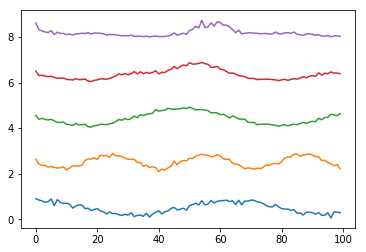

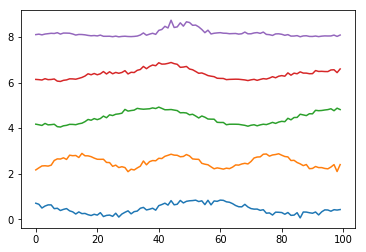

In [13]:
(X_train), (X_test) = train_test_split(X)  # retrieve data
print(X.shape, X_train.shape, X_test.shape)

#x2 = [100+x for x in range(len(y_test))]
#print(len(x2),x2)

utils.myPlot(X_test[0],2)
utils.myPlot(X_test[10],2)

In [14]:
epochs=50 # FIXME # 10
autoencoder.fit(X_train, X_train, batch_size=450, epochs=epochs, validation_split=0.05)

Train on 8455 samples, validate on 446 samples
Epoch 1/100
8455/8455 [==============================] - 13s - loss: 0.0926 - val_loss: 0.0602
Epoch 2/100
8455/8455 [==============================] - 13s - loss: 0.0583 - val_loss: 0.0575
Epoch 3/100
8455/8455 [==============================] - 14s - loss: 0.0562 - val_loss: 0.0558
Epoch 4/100
8455/8455 [==============================] - 13s - loss: 0.0547 - val_loss: 0.0546
Epoch 5/100
8455/8455 [==============================] - 13s - loss: 0.0538 - val_loss: 0.0540
Epoch 6/100
8455/8455 [==============================] - 13s - loss: 0.0532 - val_loss: 0.0533
Epoch 7/100
8455/8455 [==============================] - 13s - loss: 0.0526 - val_loss: 0.0528
Epoch 8/100
8455/8455 [==============================] - 13s - loss: 0.0522 - val_loss: 0.0523
Epoch 9/100
8455/8455 [==============================] - 13s - loss: 0.0517 - val_loss: 0.0520
Epoch 10/100
8455/8455 [==============================] - 13s - loss: 0.0513 - val_loss: 0.0517
Ep

8455/8455 [==============================] - 7s - loss: 0.0069 - val_loss: 0.0061
Epoch 87/100
8455/8455 [==============================] - 7s - loss: 0.0069 - val_loss: 0.0069
Epoch 88/100
8455/8455 [==============================] - 7s - loss: 0.0068 - val_loss: 0.0066
Epoch 89/100
8455/8455 [==============================] - 7s - loss: 0.0068 - val_loss: 0.0073
Epoch 90/100
8455/8455 [==============================] - 7s - loss: 0.0068 - val_loss: 0.0064
Epoch 91/100
8455/8455 [==============================] - 7s - loss: 0.0068 - val_loss: 0.0061
Epoch 92/100
8455/8455 [==============================] - 7s - loss: 0.0068 - val_loss: 0.0057
Epoch 93/100
8455/8455 [==============================] - 7s - loss: 0.0066 - val_loss: 0.0073
Epoch 94/100
8455/8455 [==============================] - 7s - loss: 0.0068 - val_loss: 0.0069
Epoch 95/100
8455/8455 [==============================] - 7s - loss: 0.0065 - val_loss: 0.0060
Epoch 96/100
8455/8455 [==============================] - 7s - 

1 (901, 100, 5) (901, 100, 5) 0.651685744658
2 (901, 100, 5) (901, 100, 5) 0.83487574124


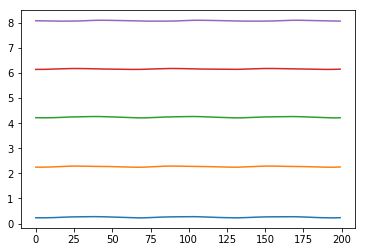

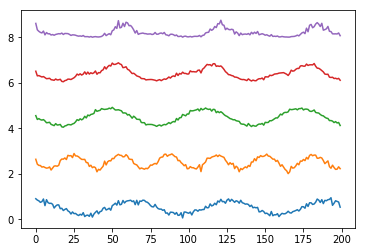

In [11]:
predicted = autoencoder.predict(X_test)  
rmse = utils.mse(X_test[:,0,:], predicted[:,0,:])
print(1, X_test.shape, predicted.shape, rmse)
#rmse = utils.mse(utils.myNorm3(X_test[:,0,:]), utils.myNorm3(predicted[:,0,:]))
#print(2, X_test.shape, predicted.shape, rmse)

#utils.myPlot(predicted[:,0,:],2)
#utils.myPlot(X_test[:,0,:],2)
utils.myPlot(predicted[:,0,:],2)
utils.myPlot(X_test[:,0,:],2)

(901, 100, 5) (901, 3)


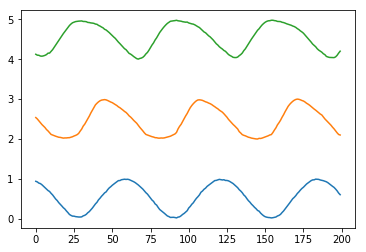

In [10]:
X_enc = encoder.predict(X_test)
print(X_test.shape, X_enc.shape)
utils.myPlot(utils.myNorm3(X_enc),2)